In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from sklearn import ensemble
from sklearn import datasets
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
import os
import time
import datetime as dt
from functools import reduce
from packages import tools
import importlib

### Predictors:
1. EURPrices lags: each hour for the past 24 hours, each day for the past 14 days (2 weeks)
2. BMImbalance Price lags: each hour for the past 6 hours; 24, 48, 72, 168
3. Wind forecast + lags
4. Demand forecast + lags
5. Availability proxies -168
6. Bid data lags (?)

### Periods for Training/Tuning and Forecast:
* Training: 2018-11-13 to 2020-05-21 (wind and demand forecasts up to 2020-05-22 since we know these values in advance)
* Forecast: 2020-05-22

### Steps:
1. Data pre-processing
    * Read in and reformat data for the above predictors
    * Organise data for fitting into function for training.
    * Ensure date ranges are consistent with above training/test periods
    * Ensure data is clean (no NaNs, no missing dates)
2. Model development, training and tuning
    * Creating implementation to take training data and fit the ensemble method (RF, bagging, and/or GB)
    * Develop a framework for hyperparameter tuning (e.g. optimal number of base estimators (trees), optimal depth parameter)
    * Should also allow for accessing important variables/metrics (e.g. OOB error, RMSE, etc.)
4. Generate forecast
    * Easiest/quickest step

In [87]:
importlib.reload(tools)

<module 'packages.tools' from 'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester\\packages\\tools.py'>

In [90]:
# Read in the datasets
price_path = "Datasets/DAMPrices.csv"
prices = tools.preprocess_price_data(price_path).drop("AuctionDateTime", axis=1)
prices = tools.price_dst_adjustment(prices, adt_column=False)

bm_price_paths = ["Datasets/BMInfo1.csv", "Datasets/BMInfo2.csv"]
bm_prices = tools.preprocess_bm_price_data(bm_price_paths)

wind_path = "Datasets/WindForecast.csv"
wind_forecast = tools.preprocess_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = "Datasets/DemandForecast.csv"
demand_forecast = tools.preprocess_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

availabilities_path = "Datasets/AvailabilityProxy.csv"
availabilities = tools.preprocess_availabilities_data(availabilities_path)

In [218]:
# Combine the datasets
planned_list = [wind_forecast, demand_forecast]
start_dates = list(map(lambda var: var.index[0], [prices, bm_prices, availabilities]+planned_list))
latest_start_date = max(start_dates)
target_end_date = prices.index[-1]

# Check for variables that do not have enough data for forecast date (last day of prices)
for var in planned_list+[prices,availabilities]:
    if var.index[-1] < target_end_date:
        print(f"Must not include {var.columns}")
        
planned_variables = reduce(lambda df1, df2: df1.join(df2), planned_list).loc[latest_start_date:target_end_date]

# Split into training and test set
last_day_of_data = dt.datetime.combine(prices.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')

# Test data
test_prices = prices.loc[test_data_index]

# Training data + predictors for forecast
train_prices = prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_bm_prices = bm_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_planned_variables = planned_variables.loc[:test_data_index[-1]]

# Build predictor dataframes
price_lags = [24,48,72,96,120,144,168]
bm_price_lags = [24,48,72,96,168]
planned_lags = [0,24,48,72,96,168]

predictors = pd.DataFrame(index=train_planned_variables.index)

# Build predictors from EURPrices
for lag in price_lags:
    predictor_name = f"{train_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from BMImbalancePrice
for lag in bm_price_lags:
    predictor_name = f"{train_bm_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_bm_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from wind and demand forecasts
for column in train_planned_variables.columns:
    for lag in planned_lags:
        predictor_name = f"{column}-{lag}"
        predictors.insert(predictors.shape[1], predictor_name, train_planned_variables[[column]])
        predictors[predictor_name] = predictors[predictor_name].shift(lag)

# Split predictors and target into training and test sets
train_predictors = predictors.drop(test_data_index)
test_predictors = predictors.loc[test_data_index]
train_target = train_prices["EURPrices"]
test_target = test_prices["EURPrices"]

# Remove rows in training set with NAs
notna_train_predictors_loc = train_predictors.notna().all(axis=1)
train_predictors = train_predictors.loc[notna_train_predictors_loc]
train_target = train_target.loc[notna_train_predictors_loc]

Must not include Index(['WIND', 'MULTI_FUEL', 'GAS', 'HYDRO', 'PEAT', 'COAL', 'PUMP_STORAGE',
       'BIOMASS', 'OIL', 'DISTILLATE', 'SOLAR', 'NONE'],
      dtype='object')


In [222]:
rand_state = 1
n_iters = 75

params = {
    "n_estimators": [50,75,100,125],
    "max_depth": list(range(2,52,2)),
    "max_features": [round(i*0.1*train_predictors.shape[1]) for i in range(1,11)]
}
rf_estimator = ensemble.RandomForestRegressor(random_state=rand_state, oob_score=True)
random_search = model_selection.RandomizedSearchCV(rf_estimator, params, n_iter=n_iters, cv=5,random_state=rand_state,
                                                scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
random_search.fit(X=train_predictors, y=train_target)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=True,
                                                   random_stat...0

In [223]:
random_search.cv_results_

{'mean_fit_time': array([29.50811687, 15.750419  ,  7.35752115,  5.34231071,  3.83135166,
         7.34038587, 16.46122894, 10.16162086, 30.29421668,  2.50310493,
         8.18377528, 10.60496621,  5.13586245, 17.65407653, 13.42840157,
         5.35035472,  5.01055675,  1.64215684,  2.83395085,  8.08385   ,
        18.83419137, 13.58187404, 29.73461566, 18.91957364, 20.13858104,
        16.92692747,  5.25599327, 10.57768321, 18.25824156, 13.072861  ,
        23.68913445, 29.17516356, 10.93883686, 12.90092368,  4.12745571,
        22.9365726 ,  9.52684293,  3.76478972,  3.89266286, 12.24150162,
        12.2022656 , 11.41543045,  4.06836596,  6.08517771,  5.29216976,
        11.00617547, 11.05337968,  1.12084465,  8.98514004, 32.29766412,
        21.84822779,  5.15760431, 35.45925789,  5.38738947,  6.39007921,
        14.83033137,  5.75819774, 21.39022861,  8.01097264,  5.87727971,
        23.03148713, 21.17595749, 29.55833616, 11.8764327 , 17.72598648,
         5.85613613,  9.94041119, 

In [224]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=26,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=125,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [251]:
test_df = pd.DataFrame(test_target)
test_df["Forecast"] = random_search.predict(test_predictors)

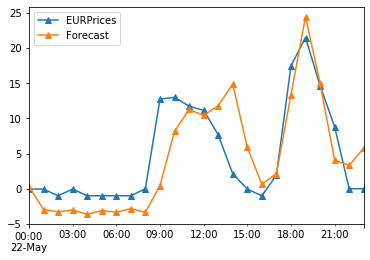

In [280]:
test_df.plot(marker='^')
plt.show()

In [281]:
test_df = pd.DataFrame(test_target)
test_df["Forecast"] = random_search.predict(test_predictors)
print("MSE:",np.sqrt(metrics.mean_squared_error(test_df["Forecast"], test_df["EURPrices"])))
print("MAE:",metrics.mean_absolute_error(test_df["Forecast"], test_df["EURPrices"]))

MSE: 4.741448894340772
MAE: 3.541441666666666


In [288]:
print("OOB MSE:", np.sqrt(metrics.mean_squared_error(random_search.best_estimator_.oob_prediction_, train_target)))
print("OOB MAE:", metrics.mean_absolute_error(random_search.best_estimator_.oob_prediction_, train_target))

OOB MSE: 9.350476242281038
OOB MAE: 5.5944570333045185


In [277]:
importances = pd.DataFrame(index=train_predictors.columns)
importances.insert(0, "importances", random_search.best_estimator_.feature_importances_)

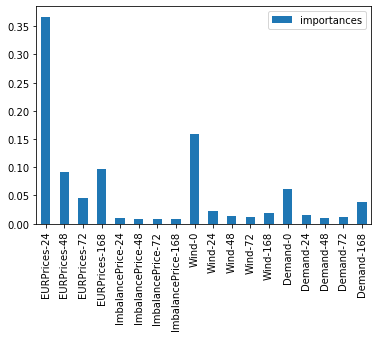

In [278]:
%matplotlib inline
importances.plot.bar()
plt.show()